Finalizado experimento con 30 muestras de 100 valores
Tiempo estimado del proyecto es de 11.60 minutos
Inferior 11.54 < u < Superior 11.66 con 99% de confianza 
 
Porcentaje de Criticidad de las tareas 
['Hacer Tostadas', 'Tostadas con Mantequilla'] 6.17% 
['Romper Huevos', 'Revolver Huevos', 'Cocinar Huevos'] 64.77% 
['Freir Tocino'] 29.07% 


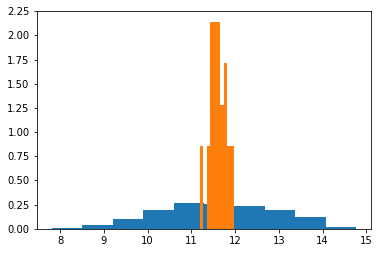

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from criticalpath import Node
import math
import ast
from __future__ import division
%matplotlib inline

CANT_MUESTRAS = 30 # cantidad total de muestras a obtener
TAM_MUESTRA = 100 # tamaño de cada muestra.
VALOR_Z = 2.57

ROMPER_HUEVOS = {
    'id':1,
    'nombre':'Romper Huevos',
    'low':2,
    'high': 4,
    'tiempos':[],
    'predecesoras': []
}
REVOLVER_HUEVOS = {
    'id':2,
    'nombre':'Revolver Huevos',
    'low':3,
    'high': 6,
    'tiempos':[],
    'predecesoras': [1]
}
COCINAR_HUEVOS = {
    'id':3,
    'nombre':'Cocinar Huevos',
    'low':2,
    'high': 5,
    'tiempos':[],
    'predecesoras': [2]
}
HACER_TOSTADAS = {
    'id':4,
    'nombre':'Hacer Tostadas',
    'low':3,
    'high': 6,
    'tiempos':[],
    'predecesoras': []
}
TOSTADAS_MANTEQUILLA = {
    'id':5,
    'nombre':'Tostadas con Mantequilla',
    'low':2,
    'high': 6,
    'tiempos':[],
    'predecesoras': [4]
}

FREIR_TOCINO = {
    'id':6,
    'nombre':'Freir Tocino',
    'low':4,
    'high': 14,
    'tiempos':[],
    'predecesoras': []
}

TAREAS = [
    ROMPER_HUEVOS, REVOLVER_HUEVOS, COCINAR_HUEVOS, HACER_TOSTADAS, TOSTADAS_MANTEQUILLA, FREIR_TOCINO
]

def getNombreTareaById(id_tarea):
    tarea = filter(lambda tarea: tarea['id'] == id_tarea,TAREAS)
    if tarea:
        return tarea[0]['nombre']
    return None
# Cada tarea tiene lista de timpos. tiempo.length == corridas que siguen distribucion uniform
def generarTiempos(tareas, corridas):
    for tarea in tareas:
        tarea['tiempos'] = np.random.uniform(tarea['low'], tarea['high'], corridas) # [ini, fin)
        
# obtenemos ruta critica del proyecto con los tiempos previamente generados.

def getNodo(nodos, id_tarea):
    nodo = None
    for i in range(len(nodos)):
        if int(str(nodos[i])) == id_tarea:
            nodo = nodos[i]
            break
    return nodo       
    
def getDuracionRutaCritica(tareas, indice_tiempo):
    p = Node('project')
    criticidad = {}
    nodos = []
    #creamos los nodos = Tareas
    for tarea in tareas:
        nodo = p.add(Node(tarea['id'], duration = tarea['tiempos'][indice_tiempo]))    
        nodos.append(nodo)
    #creamos los links = predecesoras
    for tarea in tareas:
        nodo_tarea = getNodo(nodos, tarea['id'])
        for id_predecesora in tarea['predecesoras']:
            nodo_tarea_predecesora = getNodo(nodos, id_predecesora)
            p.link(nodo_tarea_predecesora, nodo_tarea)
    p.update_all()
    path = str(p.get_critical_path())
    result = {'duration':p.duration, 'tarea_critica': path}
    return result

def getMuestraProyecto(tareas, tam_muestra):
    muestra_tiempos = []
    criticidad = {}
    for i in range(tam_muestra):
        tiempo_y_ruta_critica = getDuracionRutaCritica(tareas, i)
        if tiempo_y_ruta_critica['tarea_critica'] in criticidad:
            criticidad[tiempo_y_ruta_critica['tarea_critica']] += 1
        else:
            criticidad[tiempo_y_ruta_critica['tarea_critica']] = 1
        tiempo_un_proyecto = tiempo_y_ruta_critica['duration']
        muestra_tiempos.append(tiempo_un_proyecto)
    #print "Muestreo de tiempos %s" % muestra_tiempos
    #print "CRITICIDAD %s"%(criticidad) 
    result = {'muestra_tiempos':muestra_tiempos, 'criticidad':criticidad}
    return result

def getMuestras(tareas, cant_muestras, tam_muestra):
    muestras = []
    criticidad = []
    for i in range(cant_muestras):
        generarTiempos(tareas, tam_muestra)
        muestra_y_criticidad = getMuestraProyecto(tareas, tam_muestra)
        criticidad.append(muestra_y_criticidad['criticidad'])
        muestras.append(muestra_y_criticidad['muestra_tiempos'])
    result = {'muestras':muestras, 'criticidad':criticidad}
    return result
    
def getPromediosMuestras(muestras):
    promedios = []
    return map(lambda muestra: np.average(muestra), muestras)
        
def getPromedioProyecto(promedios, valor_z):
    desvio = np.std(promedios)
    promedio = np.average(promedios)
    inferior = promedio - (desvio * valor_z / math.sqrt(len(promedios)))
    superior = promedio + (desvio * valor_z / math.sqrt(len(promedios)))
    return {'promedio': promedio, 'inferior':inferior, 'superior':superior}
    
def getTotalesCriticidad(arreglo_criticidad):
    contador_criticidad = {}
    for criticidad in arreglo_criticidad:
        for ruta, cantidad in criticidad.items():
            if ruta in contador_criticidad:
                contador_criticidad[ruta] += cantidad
            else:
                contador_criticidad[ruta] = cantidad
    return contador_criticidad

def getNombreTareas(arreglo_ids_tareas):
    nombres = []
    for id_tarea in arreglo_ids_tareas:
        nombres.append(getNombreTareaById(id_tarea))
    return nombres
        
def getPromedioCriticidad(arreglo_criticidad):
    # sumamos totales de las rutas criticas
    contador_criticidad = getTotalesCriticidad(arreglo_criticidad)
    total = sum(contador_criticidad.values())
    result = {}
    # obtenemos el porcentaje de cada ruta critica
    for ruta, cantidad in contador_criticidad.items():
        result[ruta] = (cantidad * 100) / total
    show = []
    # creamos arreglo show con los datos para mostrar: nombre ruta critica + su porcentaje
    for ruta, cantidad in result.items():
        arreglo_ids_tareas = ast.literal_eval(ruta)
        arreglo_nombre_tareas = getNombreTareas(arreglo_ids_tareas)
        show.append({"ruta":arreglo_nombre_tareas, 'porcentaje': cantidad})
    return show

def graficar(arreglo_muestras):    
    plt.hist(arreglo_muestras, 10, normed=True)

def mostrarTodo(promedios, criticidad):
    print "Finalizado experimento con %d muestras de %d valores" %(CANT_MUESTRAS, TAM_MUESTRA)
    print "Tiempo estimado del proyecto es de %.2f minutos" % (promedios['promedio'])
    print  "Inferior %.2f < u < Superior %.2f con 99%% de confianza \n " % (promedios['inferior'], promedios['superior'])
    print "Porcentaje de Criticidad de las tareas "
    for c in criticidad:
        print "%s %.2f%% "%(c['ruta'], c['porcentaje'])
    
def getTotalDatosMuestrales(muestras):
    datos = np.array(muestras).flatten()
    return datos

if __name__ == '__main__':
    muestras_y_criticidad = getMuestras(TAREAS, CANT_MUESTRAS, TAM_MUESTRA) #muestras = [[muestra_1], [muestra_2]...[muestra_N]]
    promedios_muestras = getPromediosMuestras(muestras_y_criticidad['muestras']) # [np.average([muestra_1])...]
    total_datos_muestrales = getTotalDatosMuestrales(muestras_y_criticidad['muestras']) 
    dict_promedio_y_sup_inf = getPromedioProyecto(promedios, VALOR_Z)
    dict_criticidad = getPromedioCriticidad(muestras_y_criticidad['criticidad'])
    mostrarTodo(dict_promedio_y_sup_inf, dict_criticidad)
    graficar(total_datos_muestrales)
    graficar(promedios_muestras) 
